In [1]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.ops import transform

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import folium
import networkx as nx
import osmnx as ox 

ox.settings.bidirectional_network_types = ['walk', 'bike']

# Visualizing routes between BLUEbike stations in Boston
View maps here: https://nbviewer.org/github/B-Loesch/OpenSourceGIS/blob/main/blue_bike.ipynb
- Data available here: https://bluebikes.com/system-data
- Utilizes geopandas, OSMNx, and NetworkX
- Given a station name, generates number of trips between all other stations and maps the route using Folium

- Also finds the number of crashes that occured on that route (still WIP - need to gather crash data from https://apps.crashdata.dot.mass.gov/cdp/home)
- Future improvements would be visually separating routes that overlap eachother.

In [2]:
stations = pd.read_csv("Data/current_bluebikes_stations.csv", skiprows=1)
trip_df = pd.read_csv("Data/202410-bluebikes-tripdata/202410-bluebikes-tripdata.csv")

In [3]:
cities = gpd.read_file("./Data/MBTA_Extended_Service_Area.geojson")
cities_subset = cities.loc[cities["TOWN"].isin(["BOSTON", "CAMBRIDGE", "SOMERVILLE", "BROOKLINE"])]

In [ ]:
boston_crashes = pd.read_csv("Data/Boston_crash_data.csv") # placeholder dataset
boston_crashes_gdf = gpd.GeoDataFrame(
    boston_crashes, geometry = gpd.points_from_xy(boston_crashes.long, boston_crashes.lat)
).set_crs(epsg=4326)

## Using networkx and OSM to generate routes between OD-pairs

In [5]:
stations.Municipality.value_counts()

Municipality
Boston        267
Cambridge      89
Somerville     36
Salem          18
Newton         15
Brookline      14
Everett        14
Medford        11
Watertown       8
Arlington       6
Chelsea         6
Revere          4
Malden          3
Name: count, dtype: int64

In [ ]:
# can increase this to all cities, using this subset for now
stations_filter = stations[stations["Municipality"].isin(["Boston", "Cambridge", "Somerville", "Brookline"])]

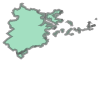

In [7]:
study_area = cities_subset.union_all()
study_area

In [8]:
def generate_bike_network(study_area):
    bike_network = ox.graph_from_polygon(study_area, network_type="bike", simplify=True)
    walk_network = ox.graph_from_polygon(study_area, network_type="walk", simplify=True)
    G = nx.compose(bike_network, walk_network)

    return(G)

bike_network = generate_bike_network(study_area)

In [9]:
stations_filter = stations[stations["Municipality"].isin(["Boston", "Cambridge", "Somerville", "Brookline"])]

stations_filter["nearest_node"] = ox.distance.nearest_nodes(bike_network, 
                                                            X = stations_filter["Long"],
                                                            Y = stations_filter["Lat"])

stations_agg = stations_filter.groupby("nearest_node").agg({
    "Number" : "first",
    "NAME" : "first",
    "Lat" : "first",
    "Long" : "first",
    "Seasonal Status" : "first",
    "Municipality" : "first",
    "Total Docks" : "sum",
    "Station ID (to match to historic system data)" : "first",
    "nearest_node" : "first",
})

C:\Users\Brandon Loesch\AppData\Local\Temp\ipykernel_25400\1951345773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_filter["nearest_node"] = ox.distance.nearest_nodes(bike_network,


In [10]:
def map_bike_routes(network, station_df = stations_agg, trip_df = trip_df, start_station_name = None, top_n = 10):
    od_counts = trip_df.value_counts(['start_station_name', 'end_station_name']).reset_index(name = 'count')
    df_subset = od_counts[od_counts.loc[:,"start_station_name"] == start_station_name]

    df_subset = df_subset.merge(station_df[["NAME","nearest_node"]], left_on="start_station_name", right_on = "NAME").drop(columns = ["NAME"]).rename(columns = {"nearest_node":"start_node"})
    df_subset = df_subset.merge(station_df[["NAME","nearest_node"]], left_on="end_station_name", right_on = "NAME").drop(columns = ["NAME"]).rename(columns = {"nearest_node":"end_node"})

    df_subset = df_subset.head(top_n)
    start_node = df_subset["start_node"].unique()[0]
    # generate routes
    routes = []
    for _, row in df_subset.iterrows():
        if nx.has_path(network, source = row["start_node"], target = row["end_node"]):
            route = nx.shortest_path(network, source = row["start_node"], target = row["end_node"])
        else:
            print(f'{row["end_station_name"]} has no routes.')
            route = None
        routes.append(route)
    
    nodes, edges = ox.graph_to_gdfs(bike_network)

    # MultiLineString - converts list of lines to a single linestring
    # edges.loc[(u, v, 0), 'geometry'] - selects line geometry that connect u node to v node
    # for u, v, in zip(route[:-1], route[1:]) - generates pairs of nodes
    # for route in routes - do this for each route
    # https://stackoverflow.com/questions/62001044/shortest-route-when-converted-to-linestring-misses-the-path-in-osmnx
    multilines = [
        MultiLineString([edges.loc[(u, v, 0), 'geometry'] for u, v, in zip(route[:-1], route[1:])]) for route in routes
    ]
    # converts this list to a geodataframe
    route_gdf = gpd.GeoDataFrame(geometry=multilines).set_crs(epsg=4326)
    route_gdf['route_id'] = range(len(route_gdf)) # assign id for joins
    # converts crs to and buffer
    route_gdf.geometry = route_gdf.to_crs(epsg = 26986).geometry.buffer(20)
    # count number of crashes within route
    route_crashes = route_gdf.sjoin(boston_crashes_gdf.to_crs(epsg = 26986)).groupby("route_id").size().rename("count")
    route_gdf = route_gdf.merge(route_crashes, on = "route_id")
    # setting the color scheme
    min_val, max_val = route_gdf["count"].min(), route_gdf["count"].max()
    norm = mcolors.Normalize(vmin = min_val, vmax = max_val)
    cmap = plt.colormaps["plasma"]
    route_gdf["color"] = route_gdf["count"].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

    # initialize map
    m = folium.Map(location = [network.nodes[start_node]['y'], network.nodes[start_node]['x']], 
                   zoom_start=13,
                   tiles="Cartodb dark_matter")
    
    # add buffered route
    folium.GeoJson(
        route_gdf,
        style_function=lambda feature: {
            "color": feature["properties"].get("color", "#000000"),  # Default to black if missing
            "weight": 1,
            "fillColor": feature["properties"].get("color", "#000000"),
            "fillOpacity": 0.6,
        }
    ).add_to(m)

    # # add route polylines
    # for i, route in enumerate(routes):
    #     if route is not None:
    #         route_coords = [(network.nodes[node]['y'], network.nodes[node]['x']) for node in route]  # Convert nodes to (lat, lon)
    #         folium.PolyLine(route_coords, 
    #                         # color=df_subset.iloc[i,]["color"], 
    #                         weight=3, 
    #                         opacity=0.8,
    #                         tooltip=f'From {start_station_name} to {df_subset.iloc[i,]["end_station_name"]}, {df_subset.iloc[i,]["count"]} total trips.').add_to(m)

    # add destination stations 
    for _, row in df_subset.iterrows():
        if row['end_station_name'] == start_station_name:
            continue
        else:
            folium.CircleMarker(
                location = [network.nodes[row['end_node']]['y'], network.nodes[row['end_node']]['x']],
                popup = f"{row['end_station_name']}",
                radius = 4,
                color = "white",
                fill = True,
                fill_color = "white",
                fill_opacity = 0.8
            ).add_to(m)
    # add start station
    folium.CircleMarker(
        location = [network.nodes[start_node]['y'], network.nodes[start_node]['x']],
        popup = f"{start_station_name}",
            radius = 6,
            color = "black",
            fill = True,
            fill_color = "black",
            fill_opacity = 1
    ).add_to(m)

    return(m)

In [11]:
m = map_bike_routes(bike_network, stations_agg, trip_df, start_station_name= "Canal St at Causeway St", top_n = 20)
m

In [12]:
from folium.plugins import HeatMap

In [13]:
boston_crashes.rename(columns={'lat': 'latitude', 'long' : 'longitude'}, inplace = True)

In [14]:
heat_data = [[row['latitude'], row['longitude']] for idx, row in boston_crashes.iterrows()]

In [15]:
HeatMap(heat_data, radius = 15, blue = 10).add_to(m)
m

## Trying to figure out a way to offset overlapping routes
- At the beginning of routes heading in the same direction, there are overlaps.
- Try to separate routes until a divergence point, and only offset the overlapping segments.
- This can be done using the routes object (which is a list of nodes that are taken to complete a route)
- Find the node value where the last point of overlap occurs, split the line at that node and overlap before it.

- Another approach could be splitting the buffered routes between overlapping and non-overlapping sections.
- This would take advantage of geom.difference() and geom.intersection()

In [173]:
def offset_route(line, index, total_routes, distance=10):
    """
    Offset routes to avoid complete overlap.
    - `index`: Order of the route
    - `total_routes`: Total number of overlapping routes
    - `distance`: Max offset distance
    """
    if total_routes == 1:
        return line  # No need to offset if there's only one route
    
    # Center the offsets around 0 (some left, some right)
    offset_amount = distance * ((index - total_routes / 2) / (total_routes / 2))
    return line.parallel_offset(offset_amount, side="right", join_style=2)